# The Buy & Eco Queues

During actual games, players will have a predetermined set of purchases they intend to make and also a predetermined way of eco'ing that they've flowcharted out. The simulator can model taking these sorts of actions with the *buy queue* and the *eco queue*. To demonstrate how these work in action, I'm going to walk through another example which shows how these queues work. Like last time, let's import the `b2sim` module:

In [48]:
import sys
sys.path.append('../')

import b2sim as b2
import copy

For our toy example, let's consider a scenario where we are playing tack wiz farm with jericho and have approached round 9. In a typical game scenario, this means the player has the following farms and defense:

| Build Item | Current Build |
|------------|---------------|
| Farms      | 2 x 200 farms |
| Defense    | 1 x 230 tack  |
|            | 1 x 022 wizard|

By halfway through Round 10, we seek the following build

| Build Item | Current Build |
|------------|---------------|
| Farms      | 2 x 200 farms |
| Defense    | 1 x 230 tack  |
|            | 1 x 024 wizard|

Like last time, we'll start by determining the round lengths and specifying our farms:

In [30]:
rounds = b2.Rounds(0.25)

farms = {
    0: b2.initFarm(rounds.getTimeFromRound(5), upgrades = [2,0,0]),
    0: b2.initFarm(rounds.getTimeFromRound(8), upgrades = [2,0,0])
}

Now, we define the buy queue. The buy queue is a list of lists. Each item in the buy queue prescribes a list of actions the player wishes to take. Every time the player receives a payment in the simulator, the simulator will check whether there is enough cash to execute the next item in the buy queue. In most cases (such as this example), items in the buy queue will just be lists with one action, but for cases like selling farms into better farm upgrades or more defense, it is useful to have an item in the buy queue which prescribes multiple actions to be taken simultaneously.

Note in our case we are also specifying a minimum time to perform each transaction. This tells the sim not to attempt the transaction until that time is reached in the simulation.

In [35]:
buy_queue = [
    [b2.jerichoSteal(steal_amount = 25, min_buy_time = rounds.getTimeFromRound(9.25))],
    [b2.buyDefense(2800+1500, min_buy_time = rounds.getTimeFromRound(10.5))]
]

Our next step is to define the eco queue. The eco queue is a list of tuples, and each tuple `(time, eco send, properties)` tells the simulator to switch to the specified eco send at the specified time with the specified properties. In our case, we will send spaced zebras for a short while on round 9 before deciding to stop and hard save for necromancer. Note for our eco queue does not have spaced zebras. That's because we'll specify spaced zebras as the starting send in the initial game state.

In [36]:
eco_queue = [
    (rounds.getTimeFromRound(9) + 1.8, 'Zero')
]

Make sure when defining the initial game state to include the queues we defined above!

In [49]:
initial_state_game = {
    'Cash': 1500,
    'Eco': 520,
    'Eco Send': 'Spaced Zebras',
    'Rounds': rounds,
    'Game Round': 9,
    'Farms': farms,
    'Buy Queue': copy.deepcopy(buy_queue),
    'Eco Queue': copy.deepcopy(eco_queue)
}

Finally, we can simulate. Here we want to check whether we can actually afford necromancer or not.

The current cash and eco are (730.4000000000017,544.3000000000004)


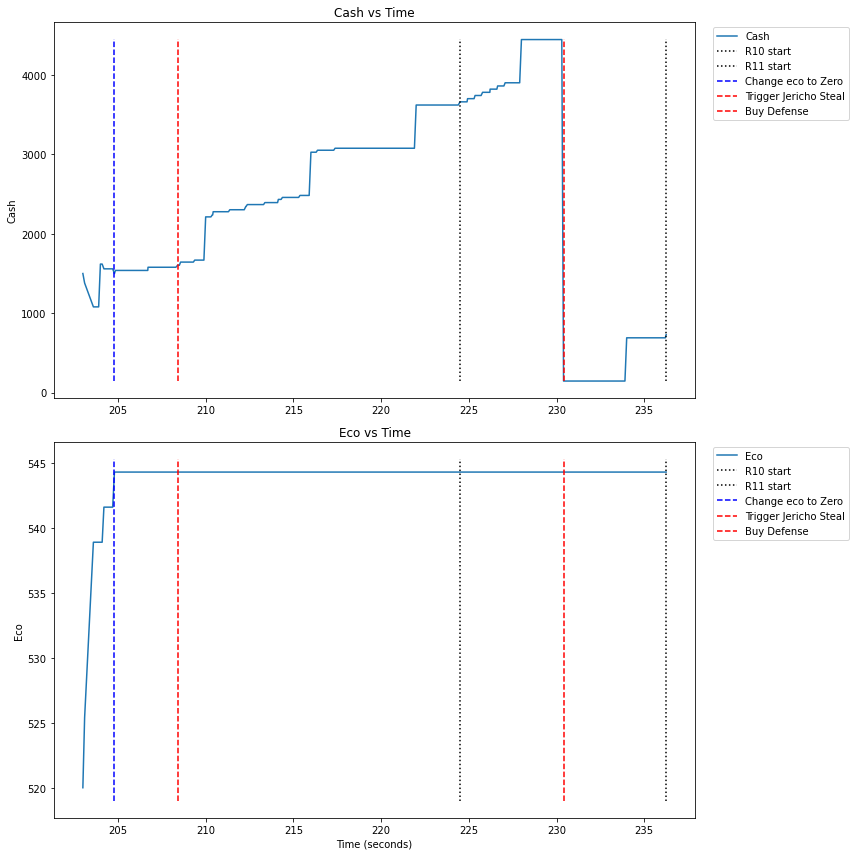

In [38]:
game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 11)
game_state.viewCashEcoHistory((12,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))

# Advanced Usage

A powerful use case for the simulator is to perform strategy *optimization*. In the above for example, we see that we afford the necromancer upgrade just fine. But what if our starting eco was lower. Could we still afford it okay? In general, what's the lowest eco amount we could have while still being able to afford necro at the right time? To answer this question, we perform optimization using the bisection method as follows:

In [50]:
def foo(starting_eco):
    buy_queue = [
        [b2.jerichoSteal(steal_amount = 25, min_buy_time = rounds.getTimeFromRound(9.25))],
        [b2.buyDefense(2800+1500, min_buy_time = rounds.getTimeFromRound(10.5))]
    ]

    eco_queue = [
        (rounds.getTimeFromRound(9) + 1.8, 'Zero')
    ]

    initial_state_game = {
        'Cash': 1500,
        'Eco': starting_eco,
        'Eco Send': 'Spaced Zebras',
        'Rounds': rounds,
        'Game Round': 9,
        'Farms': farms,
        'Buy Queue': buy_queue,
        'Eco Queue': eco_queue
    }
    game_state = b2.GameState(initial_state_game)
    game_state.fastForward(target_round = 11)

    if len(game_state.buy_queue) == 0:
        return True
    else:
        return False

In [51]:
eco_bound_low = 250
eco_bound_high = 530
iterations = 25

for i in range(iterations):
    c = 0.5*(eco_bound_low + eco_bound_high)

    if foo(c) == True:
        eco_bound_high = c
    else:
        eco_bound_low = c

print("The minimum eco which lets us afford necro is %s"%('{0:.1f}'.format(0.5*(eco_bound_low + eco_bound_high))))

The minimum eco which lets us afford necro is 398.3
